In [2]:
import sys

import numpy as np
import matplotlib.pyplot as plt
import cv2
import plyfile
import cupy as cp

In [1]:
import os
os.getenv("CUDA_PATH")

'C:\\Program Files\\NVIDIA GPU Computing Toolkit\\CUDA\\v11.7'

In [3]:
bunny = r"data/bun_zipper.ply"



def load_ply(fpath):
    with open(bunny, "rb") as f:
        return plyfile.PlyData.read(f)

bunny_ply = load_ply(bunny)

In [4]:
from cg.math3d import rot_x, rot_y, rot_z
from cg.camera_parameters import fov2focal, focal2fov




In [5]:
from numba import njit


# @njit
def bbox(pcl):
    pcl_flat = pcl.reshape(-1, 3)
    count = pcl_flat.shape[0]
    xmin, xmax = np.infty, -np.infty
    ymin, ymax = np.infty, -np.infty
    zmin, zmax = np.infty, -np.infty

    for i in range(count):
        x = pcl_flat[i, 0]
        y = pcl_flat[i, 1]
        z = pcl_flat[i, 2]

        if x<xmin:
            xmin = x
        if x >= xmax:
            xmax = x

        if y < ymin:
            ymin = y
        if y >= ymax:
            ymax = y


        if z < zmin:
            zmin = z
        if z >= zmax:
            zmax = z

    return xmin, xmax, ymin, ymax, zmin, zmax

bbox(np.array([
    [-0.2, -0.4, -0.6],
    [ 0.3, -0.5, -0.6],
    [-0.2,  0.4, -0.6],
    [ 0.3,  0.4, -0.6],
    [-0.2, -0.5,  0.7],
    [ 0.3, -0.4,  0.7],
    [-0.2,  0.4,  0.7],
    [ 0.3,  0.5,  0.7],
]))



(-0.2, 0.3, -0.5, 0.5, -0.6, 0.7)

In [6]:
def bbox_np(pcl):
    pcl = pcl.reshape(-1, 3)
    np.argmax()

(-0.0, 0.2)

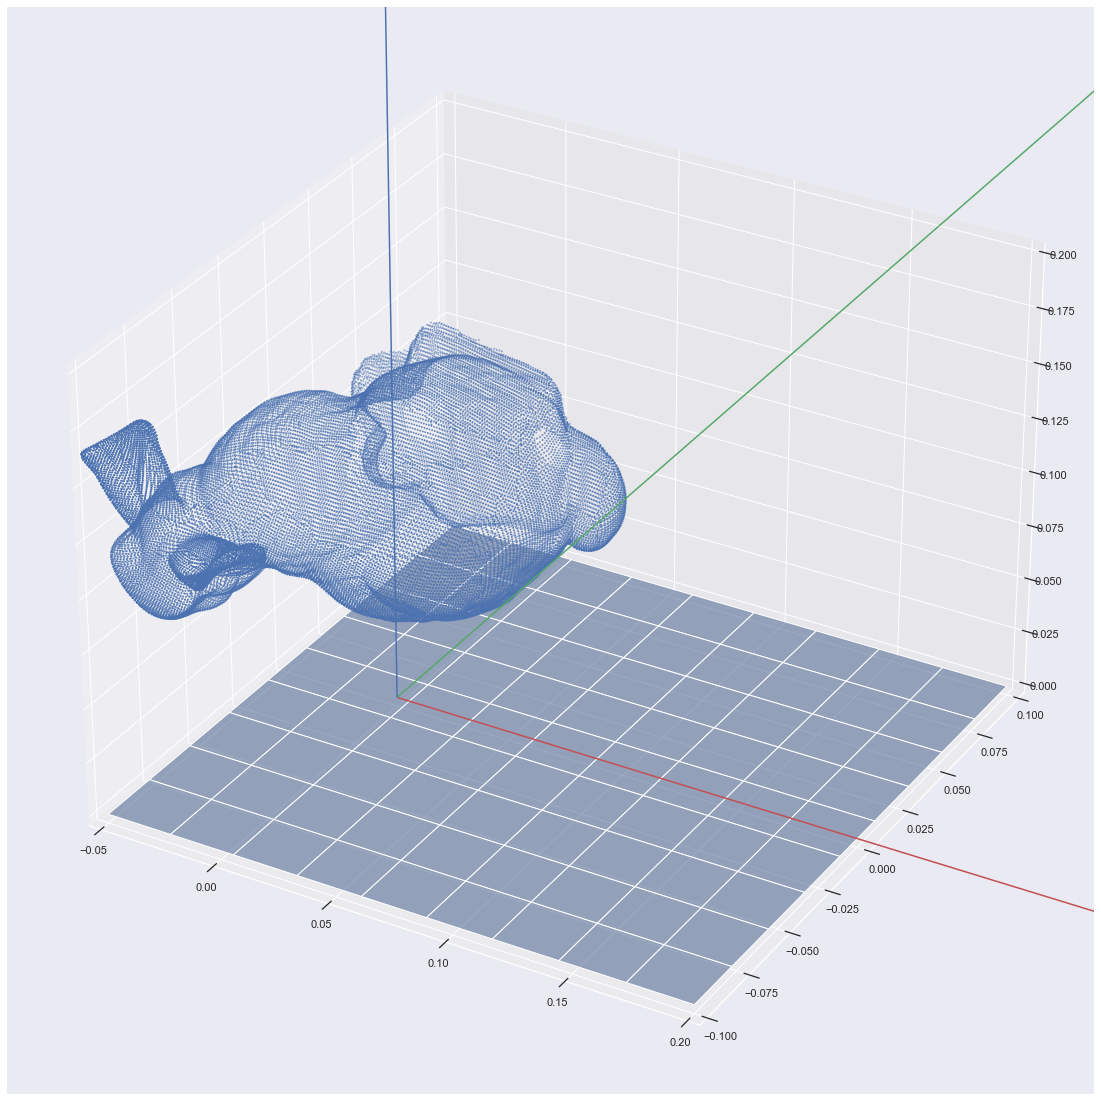

In [21]:
bunny_pcl = np.stack([
    bunny_ply['vertex'].data['x'],
    bunny_ply['vertex'].data['y'],
    bunny_ply['vertex'].data['z']
    ], axis=-1)


theta = 1* np.pi
#theta = 0
bunny_pcl_r = (rot_z(theta) @ bunny_pcl.T).T
theta_y = np.pi
bunny_pcl_r = (rot_y(theta_y) @ bunny_pcl_r.T).T


# bunny_pcl_r *= 10
bunny_pcl_r[:,0] += 0.03
bunny_pcl_r[:,1] += 0.07
bunny_pcl_r[:,2] += 0.12

bunny_pcl_r_32 = bunny_pcl_r.astype(np.float32)


fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(projection='3d')

pxx, pyy = np.meshgrid(np.linspace(-0.05, 0.2, 10), np.linspace(-0.1, 0.1, 10))
pz = 0*pxx

# plot the plane
ax.plot_surface(pxx, pyy, pz, alpha=0.5)

def plot_axes(ax):
    x, y, z = np.zeros((3,3))
    u, v, w = np.array([[1,0,0],[0,1,0],[0,0,1]])
    ax.quiver(x,y,z,u,v,w,arrow_length_ratio=0.1, color=['r', 'g', 'b'])

plot_axes(ax)

ax.scatter(bunny_pcl_r[:,0], bunny_pcl_r[:,1], bunny_pcl_r[:,2], s=1)
bunny_bbox = bbox(bunny_pcl_r)
# ax.set_xlim(bunny_bbox[0], bunny_bbox[1])
# ax.set_ylim(bunny_bbox[2], bunny_bbox[3])
# ax.set_zlim(bunny_bbox[4], bunny_bbox[5])

ax.set_xlim(-0.05, 0.2)
ax.set_ylim(-0.1, 0.1)
ax.set_zlim(-0.0, 0.2)



In [9]:
h, w = 100, 100

xs, ys = np.meshgrid(np.linspace(-20, 20, w), np.linspace(-20, 20, h))
zs = np.ones_like(xs) * 20

pcl = np.stack([xs, ys, zs], axis=-1)



In [10]:
h, w = 180,240
fx, fy = 70.0, 70.0
cx, cy = w/2, h/2
k1, k2, k3 = 0.02, 0.0, 0.0
p1, p2 = 0.0, 0.0
K = np.array([
    fx, 0, cx,
     0, fy, cy,
     0, 0, 1
]).reshape(3,3)
dist_coeffs = np.array([k1, k2, p1, p2, k3])
tvec = np.array([0.0, 0.0, 0.0])
rvec = np.eye(3)

In [11]:
def project_points(points, k, dist_coeffs):
    uvw = k @ points.reshape(-1, 3).T
    u = uvw[0,:] / uvw[2,:]
    v = uvw[1,:] / uvw[2,:]

    return u, v


def project_points_dist(points, k, dist_coeffs):
    XYZ = points.reshape(-1, 3).T
    x = XYZ[0,:] / XYZ[2,:]
    y = XYZ[1,:] / XYZ[2,:]

    r2 = x*x + y*y
    r4 = r2*r2
    r6 = r4*r2
    a1 = 2*x*y
    a2 = r2 + 2*x*x
    a3 = r2 + 2*y*y
    k1, k2, p1, p2, k3 = dist_coeffs

    cdist = (1+k1*r2 + k2*r4 + k3*r6)
    xd = x * cdist + p1*a1 + p2*a2
    yd = y * cdist + p1*a3 + p2*a1

    fx = k[0,0]
    fy = k[1,1]
    cx = k[0,2]
    cy = k[1,2]
    u =  xd * fx + cx
    v =  yd * fy + cy

    return u, v



In [ ]:


class ProjectPoints:
    def __init__(self, intrinsics, dist_coeff):
        ...

    def project(self, points):
        ...

In [12]:
cp.show_config()

OS                           : Windows-10-10.0.19041-SP0
Python Version               : 3.10.5
CuPy Version                 : 11.0.0
CuPy Platform                : NVIDIA CUDA
NumPy Version                : 1.22.4
SciPy Version                : 1.8.1
Cython Build Version         : 0.29.30
Cython Runtime Version       : 0.29.30
CUDA Root                    : C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v11.7
nvcc PATH                    : C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v11.7\bin\nvcc.EXE
CUDA Build Version           : 11020
CUDA Driver Version          : 11070
CUDA Runtime Version         : 11070
cuBLAS Version               : (available)
cuFFT Version                : 10701
cuRAND Version               : 10210
cuSOLVER Version             : (11, 4, 0)
cuSPARSE Version             : (available)
NVRTC Version                : (11, 7)
Thrust Version               : 101000
CUB Build Version            : 101000
Jitify Build Version         : <unknown>
cuDNN Build V

In [57]:
squared_diff = cp.ElementwiseKernel(
   'float32 x, float32 y',
   'float32 z',
   'z = (x - y) * (x - y)',
   'squared_diff')

x = cp.arange(10, dtype=np.float32).reshape(2, 5)
y = cp.arange(5, dtype=np.float32)
squared_diff(x, y)

array([[ 0.,  0.,  0.,  0.,  0.],
       [25., 25., 25., 25., 25.]], dtype=float32)

In [75]:
project_points_cupy = cp.RawKernel(
    r"""
    extern "C"
        __global__
        void project_points(const float* X, const float* Y, const float* Z, float *u, float *v)
        {
            int tid = blockDim.x * blockIdx.x + threadIdx.x;
            float x = X[tid] / Z[tid];
            float y = Y[tid] / Z[tid];

            float h = 180;
            float w = 240;

            float fx = 70.0f;
            float fy = 70.0f;
            float cx = w/2;
            float cy = h/2;
            float k1 = 0.0;
            float k2 = 0.02;
            float k3 = 0.0;
            float p1 = 0.0;
            float p2 = 0.0;

            float r2 = x*x + y*y;
            float r4 = r2*r2;
            float r6 = r4*r2;
            float a1 = 2*x*y;
            float a2 = r2 + 2*x*x;
            float a3 = r2 + 2*y*y;

            float frac = (1+k1*r2 + k2*r4 + k3*r6);
            float xd = x * frac + p1*a1 + p2*a2;
            float yd = y * frac + p1*a3 + p2*a1;

            u[tid] =  xd * fx + cx;
            v[tid] =  yd * fy + cy;

        }

    """, "project_points"
)


project_points_cupy.compile(log_stream=sys.stderr)


In [101]:
project_points_cupy_ewk = cp.ElementwiseKernel(
    in_params=" float32 X,  float32 Y,  float32 Z",
    out_params="float32 u, float32 v",
    operation=r"""
            float x = X / Z;
            float y = Y / Z;

            float h = 180;
            float w = 240;

            float fx = 70.0f;
            float fy = 70.0f;
            float cx = w/2;
            float cy = h/2;
            float k1 = 0.0;
            float k2 = 0.02;
            float k3 = 0.0;
            float p1 = 0.0;
            float p2 = 0.0;

            float r2 = x*x + y*y;
            float r4 = r2*r2;
            float r6 = r4*r2;
            float a1 = 2*x*y;
            float a2 = r2 + 2*x*x;
            float a3 = r2 + 2*y*y;

            float frac = (1+k1*r2 + k2*r4 + k3*r6);
            float xd = x * frac + p1*a1 + p2*a2;
            float yd = y * frac + p1*a3 + p2*a1;

            u =  xd * fx + cx;
            v =  yd * fy + cy;
    """, name="project_points"
)


project_points_cupy_ewk

In [87]:
x_gpu = cp.array(bunny_pcl_r_32[:,0])
y_gpu = cp.array(bunny_pcl_r_32[:,1])
z_gpu = cp.array(bunny_pcl_r_32[:,2])
u_gpu = cp.zeros_like(z_gpu)
v_gpu = cp.zeros_like(z_gpu)

In [95]:
# '%%timeit
project_points_cupy((1,), (1,), (x_gpu, y_gpu, z_gpu, u_gpu, v_gpu))

In [107]:
# %%timeit
u_cp, v_cp = project_points_cupy_ewk(x_gpu, y_gpu, z_gpu)


In [93]:
u_gpu.get().shape

(35947,)

In [60]:
add_kernel = cp.RawKernel(r'''
extern "C" __global__
void my_add(const float* x1, const float* x2, float* y) {
    int tid = blockDim.x * blockIdx.x + threadIdx.x;
    y[tid] = x1[tid] + x2[tid];
}
''', 'my_add')
x1 = cp.arange(25, dtype=cp.float32).reshape(5, 5)
x2 = cp.arange(25, dtype=cp.float32).reshape(5, 5)
y = cp.zeros((5, 5), dtype=cp.float32)
add_kernel((5,), (5,), (x1, x2, y))  # grid, block and arguments
y

array([[ 0.,  2.,  4.,  6.,  8.],
       [10., 12., 14., 16., 18.],
       [20., 22., 24., 26., 28.],
       [30., 32., 34., 36., 38.],
       [40., 42., 44., 46., 48.]], dtype=float32)

In [409]:
import numpy as np
import pyopencl as cl

a_np = np.random.rand(50000).astype(np.float32)
b_np = np.random.rand(50000).astype(np.float32)

ctx = cl.create_some_context()
queue = cl.CommandQueue(ctx)

mf = cl.mem_flags
a_g = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=a_np)
b_g = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=b_np)

prg = cl.Program(ctx, """
__kernel void projectpoint(
    __global const float *p3d_g, __constant const float *intrinsics,  __constant const float *dist_coeff, __global float *u_g, __global float *v_g)
{
  int gid = get_global_id(0);

  float x =

  res_g[gid] = a_g[gid] + b_g[gid];
}
""").build()

res_g = cl.Buffer(ctx, mf.WRITE_ONLY, a_np.nbytes)
knl = prg.sum  # Use this Kernel object for repeated calls
knl(queue, a_np.shape, None, a_g, b_g, res_g)

res_np = np.empty_like(a_np)
cl.enqueue_copy(queue, res_np, res_g)

# Check on CPU with Numpy:
print(res_np - (a_np + b_np))
print(np.linalg.norm(res_np - (a_np + b_np)))
assert np.allclose(res_np, a_np + b_np)

[0. 0. 0. ... 0. 0. 0.]
0.0


In [80]:
# %%timeit

# print(f"hfov: {np.rad2deg(focal2fov(fx, w))}")
# print(f"vfov: {np.rad2deg(focal2fov(fy, h))}")
u, v = project_points(bunny_pcl_r, K, dist_coeffs)



In [19]:
bunny_pcl_r_32 = bunny_pcl_r.astype(np.float32)

In [81]:
%%timeit
ud, vd = project_points_dist(bunny_pcl_r_32, K, dist_coeffs)

448 µs ± 83.4 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [82]:
#  %%timeit

cv_projected, _ = cv2.projectPoints(bunny_pcl_r, cameraMatrix=K, distCoeffs=dist_coeffs, rvec=rvec, tvec=tvec)

35947
35546
35947
35947


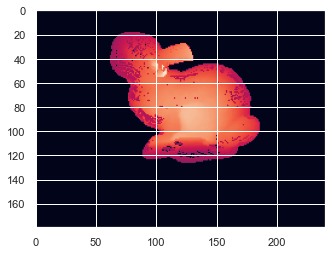

In [60]:
uv_cv = np.squeeze(cv_projected)
u_cv = uv_cv[:, 0]
v_cv = uv_cv[:, 1]

print(len(u_cv))
print(len(np.where((u_cv>=0) * (u_cv<h))[0]))
print(len(np.where((v_cv>=0) * (v_cv<w))[0]))

unn = np.round(u_cv).astype(int)
vnn = np.round(v_cv).astype(int)


inds_int = np.where((unn>=0) * (unn<w) * (vnn>=0) * (vnn<h))[0]

# print(len(inds))
print(len(inds_int))




target = np.zeros(shape=(h, w))

np.where(unn[inds_int]> 238)


target[vnn[inds_int], unn[inds_int]]= bunny_pcl_r[inds_int, 2]

plt.imshow(target)



In [84]:

from numba import njit


def make_img(u, v, pcl):
    im = np.ones(shape=(h, w)) * 2
    uu = np.round(u).astype(int)
    vv = np.round(v).astype(int)

    inds = np.where((0<=uu) * (uu<w) * (0<=vv) * (vv<h))[0]
    uc = uu[inds]
    vc = vv[inds]

    im[vc, uc] = pcl[inds, 2]
    return im

#@njit
def make_img_zbuf(u, v, pcl):
    im = np.ones(shape=(h, w)) * 2
    uu = np.round(u).astype(int)
    vv = np.round(v).astype(int)

    inds = np.where((0<=uu) * (uu<w) * (0<=vv) * (vv<h))[0]

    for i in range(len(inds)):
        uc = uu[inds[i]]
        vc = vv[inds[i]]
        z = pcl[inds[i],2]
        if im[vc, uc] >= z:
            im[vc, uc] = z

    return im

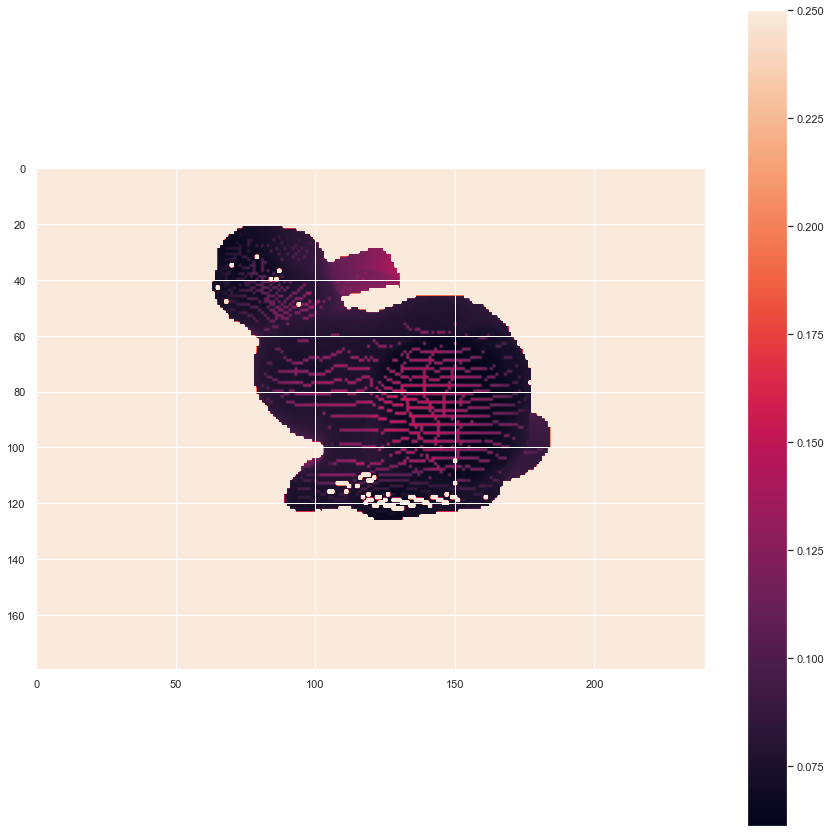

In [57]:
im = make_img_zbuf(u, v, bunny_pcl_r)
plt.figure(figsize=(15,15))
plt.imshow(im, vmax=0.25)
plt.colorbar()

In [53]:
# %%timeit

im = make_img_zbuf(u, v, bunny_pcl_r)

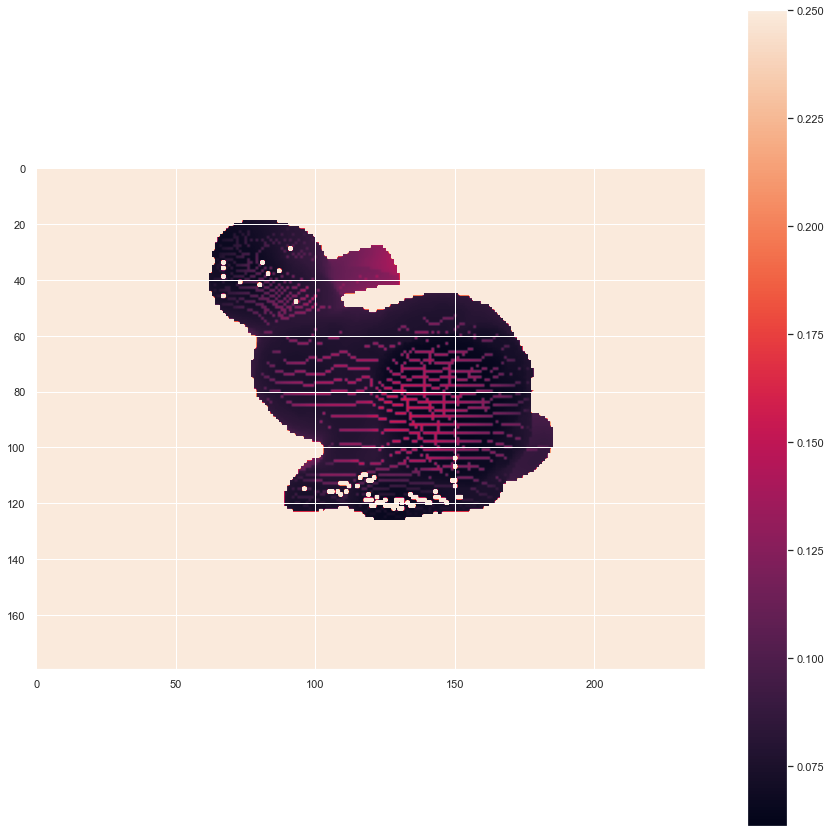

In [56]:
imd = make_img_zbuf(ud, vd, bunny_pcl_r)
plt.figure(figsize=(15,15))
plt.imshow(imd, vmax=0.25)
plt.colorbar()

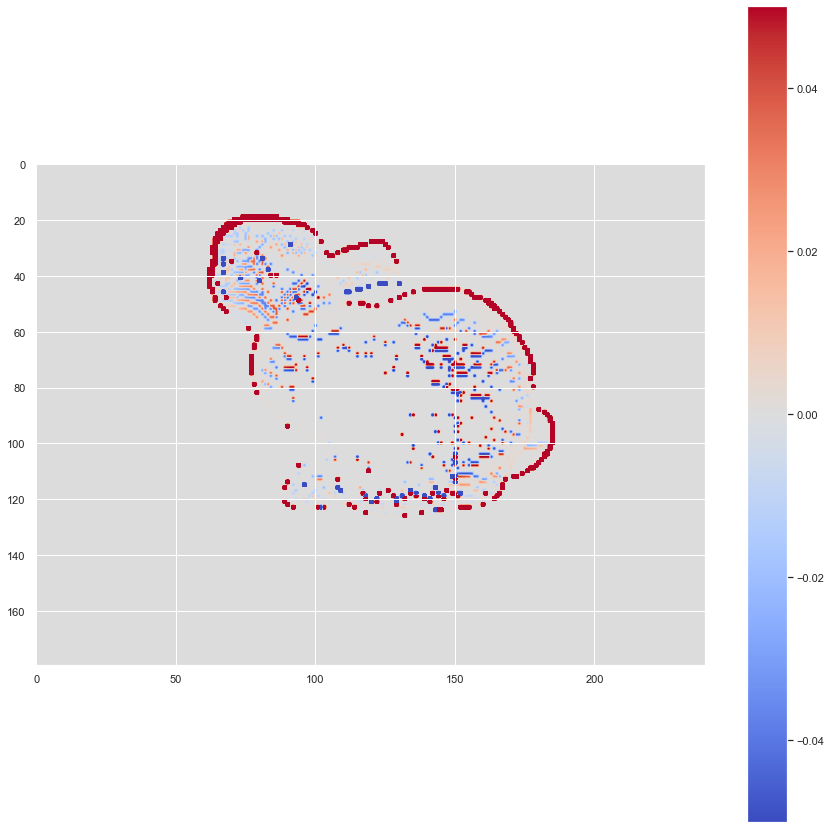

In [61]:
plt.figure(figsize=(15,15))
plt.imshow(im-imd, cmap='coolwarm', vmin=-0.05, vmax=0.05)
plt.colorbar()

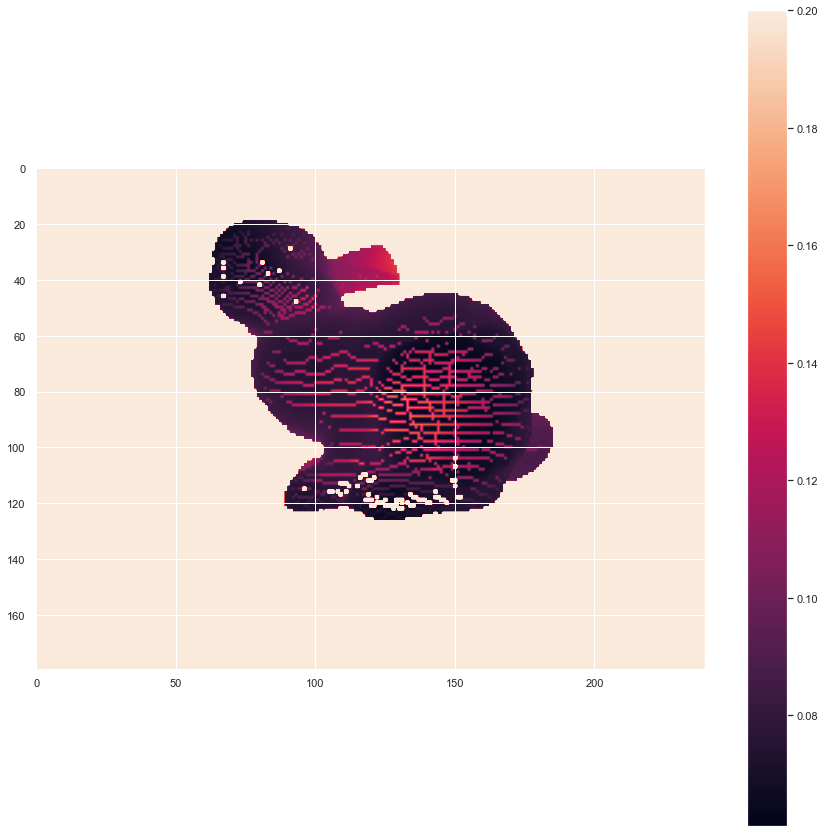

In [62]:
cv_projected = np.squeeze(cv_projected)
u_cv = cv_projected[:,0]
v_cv = cv_projected[:,1]

im_cvd = make_img_zbuf(u_cv, v_cv, bunny_pcl_r)
plt.figure(figsize=(15,15))
plt.imshow(im_cvd, vmax=0.20)
plt.colorbar()

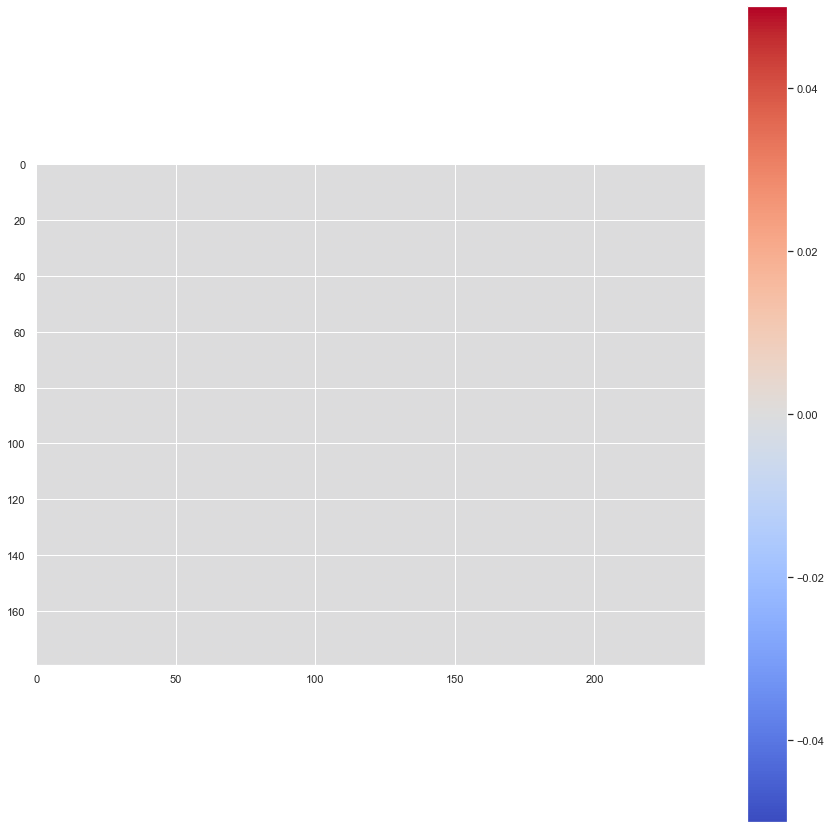

In [740]:
plt.figure(figsize=(15,15))
plt.imshow(imd-im_cvd, cmap='coolwarm', vmin=-0.05, vmax=0.05)
plt.colorbar()

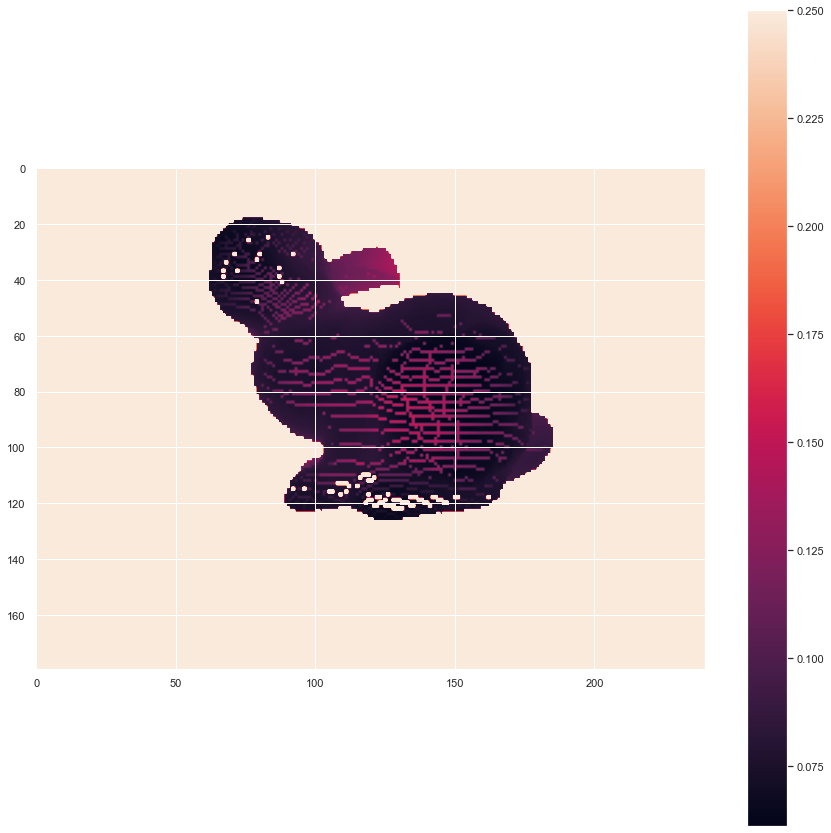

In [109]:
im = make_img_zbuf(u_cp.get(), v_cp.get(), bunny_pcl_r_32)
plt.figure(figsize=(15,15))
plt.imshow(im, vmax=0.25)
plt.colorbar()

## Benchmarks

In [72]:
import timeit

fpaths = [
    "data/bunny_zipper.ply",
    # "data/bunny_zipper_res2.ply",
    # "data/bunny_zipper_res3.ply",
    # "data/bunny_zipper_res4.ply",
]


meshdata = load_ply(fpaths[0])
vertices = np.stack([
    meshdata['vertex'].data['x'],
    meshdata['vertex'].data['y'],
    meshdata['vertex'].data['z']
], axis=-1)


theta = 1* np.pi
#theta = 0
vertices = (rot_z(theta) @ vertices.T).T
theta_y = np.pi
vertices = (rot_y(theta_y) @ vertices.T).T


# vertices *= 10
vertices[:,0] += 0.07
vertices[:,1] += 0.07
vertices[:,2] += 0.12

results = {}


In [73]:

# numpy, pinhole only
u_ph, v_ph = project_points(vertices, K, dist_coeffs)
loop_ph = 10000
results_ph = timeit.timeit(lambda: project_points(vertices, K, dist_coeffs), number=loop_ph)
results["numpy_pinhole"] = (u_ph, v_ph, results_ph/loop_ph)


In [74]:
# numpy, pinhole+brown radial
u_br, v_br = project_points_dist(vertices, K, dist_coeffs)
loop_br = 1000
results_br = timeit.timeit(lambda: project_points_dist(vertices, K, dist_coeffs), number=loop_br)
results["numpy_brownradial"] = (u_br, v_br, results_br/loop_br)

In [75]:
# opencv, pinhole+brown radial
cv_projected, _ = cv2.projectPoints(vertices, cameraMatrix=K, distCoeffs=dist_coeffs, rvec=rvec, tvec=tvec)
uv_cv = np.squeeze(cv_projected)
u_cv = uv_cv[:, 0]
v_cv = uv_cv[:, 1]
loop_cv = 100
results_cv = timeit.timeit(lambda: cv2.projectPoints(vertices, cameraMatrix=K, distCoeffs=dist_coeffs, rvec=rvec, tvec=tvec), number=loop_cv)
results["cv_brownradial"] = (u_cv, v_cv, results_cv/loop_cv)


[Text(0, 8, '0.030923'), Text(0, 8, '0.001296'), Text(0, 8, '0.000119')]

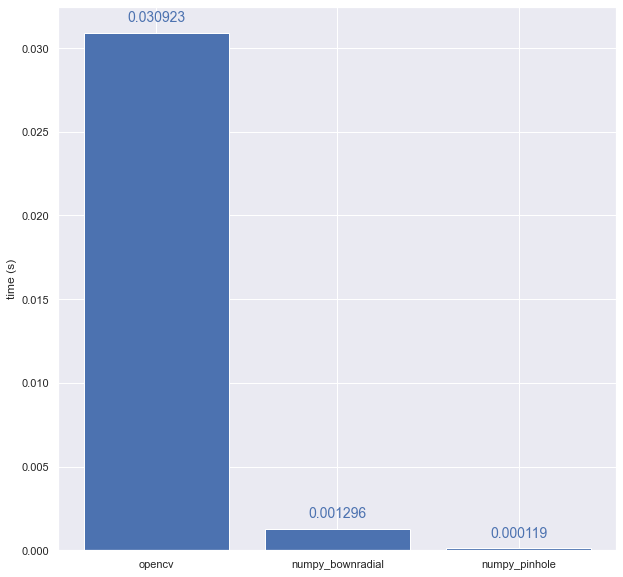

In [76]:
fig = plt.figure(figsize=(10,10))
ax = fig.subplots()
time_s = [results["cv_brownradial"][2], results["numpy_brownradial"][2], results["numpy_pinhole"][2]]
bars = ax.bar([0, 1, 2], time_s)
ax.set_ylabel("time (s)")
ax.set_xticks([0, 1, 2], ["opencv", "numpy_bownradial", "numpy_pinhole"])
ax.bar_label(bars, labels=['%f' % e for e in time_s],
             padding=8, color='b', fontsize=14)

In [807]:
import pandas as pd
pd.DataFrame(results)

,numpy_pinhole,numpy_brownradial,cv_brownradial
0,"[103.95569931808546, 99.73456511444776, 100.87...","[104.62162613076508, 100.25690326204469, 101.4...","[104.62162613076508, 100.25690326204469, 101.4..."
1,"[60.61121156334451, 59.9794717038595, 49.22804...","[60.7421762322183, 60.08428128150021, 49.21988...","[60.7421762322183, 60.08428128150021, 49.21988..."
2,0.000158,0.001044,0.021128


Text(0.5, 1.0, 'diff(np_brownradial, cv_brownradial), mean=0.0')

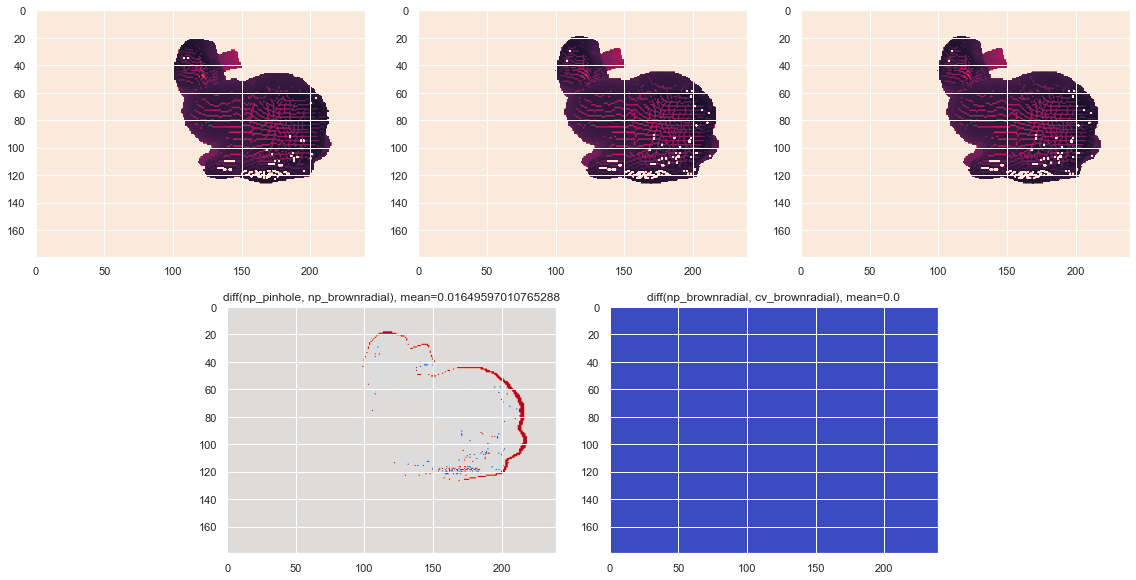

In [77]:
fig = plt.figure(figsize=(20, 10))
ax = fig.subplot_mosaic("""
AABBCC
.DDEE.
""")

im_ph = make_img_zbuf(results["numpy_pinhole"][0], results["numpy_pinhole"][1], vertices)
im_br = make_img_zbuf(results["numpy_brownradial"][0], results["numpy_brownradial"][1], vertices)
im_cv = make_img_zbuf(results["cv_brownradial"][0], results["cv_brownradial"][1], vertices)

ax['A'].imshow(im_ph, vmax=0.25, vmin=0.05)
ax['B'].imshow(im_br, vmax=0.25, vmin=0.05)
ax['C'].imshow(im_cv, vmax=0.25, vmin=0.05)
ax['D'].imshow(im_ph-im_br, cmap="coolwarm")
ax['D'].set_title(f"diff(np_pinhole, np_brownradial), mean={np.mean(im_ph-im_br)}")
ax['E'].imshow(im_br-im_cv, cmap="coolwarm")
ax['E'].set_title(f"diff(np_brownradial, cv_brownradial), mean={np.mean(im_br-im_cv)}")

[[0. 1.]
 [1. 1.]
 [2. 1.]
 [3. 1.]]


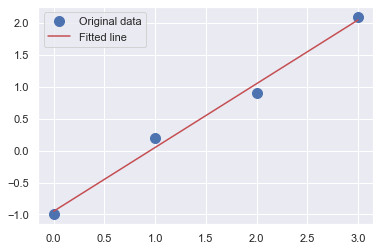

In [3]:
import matplotlib.pyplot as plt
import numpy as np

x = np.array([0, 1, 2, 3])
y = np.array([-1, 0.2, 0.9, 2.1])

A = np.vstack([x, np.ones(len(x))]).T
print(A)
m, c = np.linalg.lstsq(A, y, rcond=None)[0]

_ = plt.plot(x, y, 'o', label='Original data', markersize=10)
_ = plt.plot(x, m*x + c, 'r', label='Fitted line')
_ = plt.legend()
plt.show()

In [19]:
def project3d_to_2d(points, camera_matrix, distortion_coefficients):
    # project 3d points to 2d points
    # points: (N, 3)
    # camera_matrix: (3, 3)
    # distortion_coefficients: (1, 4)`
    # return: (N, 2)
    points = np.array(points)
    camera_matrix = np.array(camera_matrix)
    distortion_coefficients = np.array(distortion_coefficients)
    assert points.shape[1] == 3
    assert camera_matrix.shape == (3, 3)
    assert distortion_coefficients.shape == (1, 4)
    return np.linalg.lstsq(camera_matrix @ points.T, distortion_coefficients)[0].T



project3d_to_2d(vertices , K, dist_coeffs[:4].reshape(1, 4))



LinAlgError: Incompatible dimensions